In [10]:
%matplotlib inline
from IPython.display import display, clear_output
import pandas as pd
import string
import torch
import torch.nn as nn
import numpy as np
from math import floor, ceil
import sys
import matplotlib
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence, pad_sequence

In [2]:
def char_to_onehot(char):
    return [0 if char!=alphabet[i] else 1 for i, _ in enumerate(alphabet)]
def encode_sequence(sequence):
    seq = list(sequence)
    seq.insert(0, "<SOS>")
    out = [char_to_onehot(char) for char in seq]
    return out
def decode_sequence(sequence):
    chars = [alphabet[torch.argmax(char)] for char in sequence]
    decoded = ""
    for char in chars:
        decoded += char
    return decoded

In [3]:
df = pd.read_csv("./treffer.csv", sep=';')
df.drop(columns=["Datenbestand", "Aktenzeichen/Registernummer", "Aktenzustand"], inplace=True)
everything = []
for _, row in df.iterrows():
    everything += list(row["Markendarstellung"])
alphabet = ["<pad>"] + list(set(everything)) + ["<SOS>", "<EOS>"]
print(len(alphabet))

133


In [4]:
features =[encode_sequence(seq["Markendarstellung"]) for i, seq in df.iterrows()]
targets = [[alphabet.index(char) for char in list(seq["Markendarstellung"])]+[len(alphabet)-1]\
                  for i, seq in df.iterrows()]

In [50]:
#forming into the batches
def get_batch(features, targets, i, n_batches):
    batch_len = int(floor(len(features)/n_batches))
    batch_features = sorted(features[i*batch_len:(i+1)*batch_len], key=lambda x: len(x), reverse=True)
    batch_targets = sorted(targets[i*batch_len:(i+1)*batch_len], key=lambda x: len(x), reverse=True)
    return (nn.utils.rnn.pack_sequence([torch.tensor(seq, dtype=torch.float32).view(-1, len(alphabet))\
                                        for seq in batch_features]),\
            pad_sequence([torch.tensor(target) for target in batch_targets]), len(batch_features))

In [57]:
class CharPredictor(nn.Module):
    def __init__(self, structure):
        super(CharPredictor, self).__init__()
        self.structure = structure
        self.layers = len(structure)
        self.lstms = [nn.LSTM(i, o) for i, o in zip(structure[:-2], structure[1:-1])]
        self.final = nn.Linear(structure[-2], structure[-1])
        self.activation = nn.Softmax(dim=2)
    def forward(self, seq, keep_hidden_state=False, batch_size=1, plots={}):
        if "activations" in plots:
            means = []
        if "stds" in plots:
            stds = []
        if "variances" in plots:
            variances = []
        if not keep_hidden_state:
            self.init_hidden(batch_size)
        for i, lstm in enumerate(self.lstms):
            if i != 0:
                out, self.hidden[i] = lstm(out, self.hidden[i])
            else:
                out, self.hidden[i] = lstm(seq, self.hidden[i])
            if "activations" in plots:
                means.append(out.data.abs().mean().item())  
            if "stds" in plots:
                stds.append(out.data.std().item())
            if "variances" in plots:
                variances.append(out.data.var().item())
        out = pad_packed_sequence(out)[0]
        out = self.activation(self.final(out))
        if "activations" in plots:
            means.append(out.mean().item())
            plots["activations"].set_data(range(len(self.structure)-1), means)
        if "stds" in plots:
            stds.append(out.std().item())
            plots["stds"].set_data(range(len(self.structure)-1), stds)
        if "variances" in plots:
            variances.append(out.var().item())
            plots["variances"].set_data(range(len(self.structure)-1), variances)
        
        return out
    def train(self, seqs, targets, eval_seqs, eval_targets, epochs, n_batches, optim,
              plots={}, start_epoch=0, losses=[], eval_losses=[]):
        best_loss = 100
        criterion = nn.NLLLoss(reduction="mean")
        eval_X, eval_y, eval_batch_len = get_batch(eval_seqs, eval_targets, 0, 1)
        for epoch in range(start_epoch, epochs):
            N_batches = ceil(n_batches * (0.99**epoch))
            for batch in range(N_batches):
                model.zero_grad()
                X, y, batch_len = get_batch(seqs, targets, batch, N_batches)
                y_hat = self(X, plots=plots, batch_size=batch_len)
                loss = criterion(torch.log(y_hat).view(-1, len(alphabet)), y.view(-1))
                loss.backward()
                eval_predictions = self(eval_X, batch_size=eval_batch_len)
                eval_loss = criterion(torch.log(eval_predictions).view(-1, len(alphabet)), eval_y.view(-1))
                if "grads" in plots:
                    grads = [lstm.weight_ih_l0.grad.abs().mean() for lstm in self.lstms] + [self.final.weight.grad.max()]
                    print(len(grads))
                optim.step()      
                clear_output()
                print(f'{epoch}:{batch}|{loss.detach().numpy()}|{eval_loss.detach().numpy()}' )
                losses.append(loss)
                eval_losses.append(eval_loss)
                if plots != {}:
                    if "loss" in plots:
                        plots["loss"].set_data(range(len(losses)), losses)
                    if "grads" in plots:
                        plots["grads"].set_data(range(len(self.structure)-1), grads)
                    if "eval_loss" in plots:
                        plots["eval_loss"].set_data(range(len(eval_losses)), eval_losses)
                    display(plots["fig"])
                if(loss<3 and loss<best_loss):
                    self.save_checkpoint(losses, epoch, batch, optim)
                    best_loss = loss
                    print("saved checkpoint")
    def init_hidden(self, batches):
        self.hidden = [(torch.zeros(1, batches, layer_size),
                       torch.randn(1, batches, layer_size))for layer_size in self.structure[1:]] 
    def save_checkpoint(losses, epoch, batch, optim):
        torch.save({
            "model_state_dict":self.state_dict(),
            "optim_state_dict":optim.state_dict(),
            "losses":losses,
            "epoch":epoch,
            "batch":batch
        },f"./safepoints/safepoint_at_loss_{losses[-1]}.pt")
    
        

In [58]:
structure = (len(alphabet), 100, 100, 100, len(alphabet))
model = CharPredictor(structure)
optim = torch.optim.RMSprop(model.parameters(), lr=0.0005)

5:62|4.35146951675415|4.359177589416504


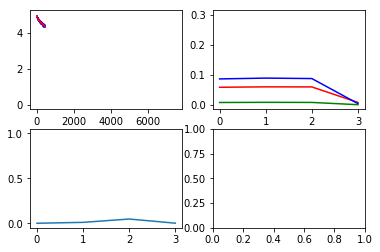

RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at ..\aten\src\TH\THGeneral.cpp:201

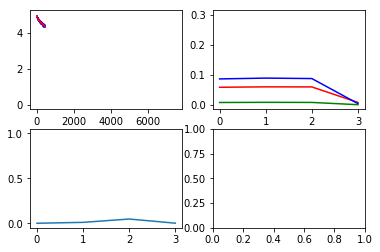

In [59]:
fig, ((lax, aax), (gax, accax)) = plt.subplots(ncols=2, nrows=2)
epochs = 100
n_batches = 75
plots = {
    "fig":fig,
    "activations":aax.plot([0, len(structure)-2], [0, 0.3], "r")[0],
    "stds":aax.plot([0, len(structure)-2], [0, 0.1], "b")[0],
    "variances":aax.plot([0, len(structure)-2], [0, 0.1], "g")[0],
    "loss":lax.plot([0, epochs*n_batches], [0, 5], "b")[0],
    "eval_loss":lax.plot([0, epochs*n_batches], [0, 5], "r")[0],
    "grads":gax.plot([0, len(structure)-2], [0, 1])[0],
#     "accuracy":accax.plot([0, epochs*n_batches], [0, 1])
}
model.train(features[100:], targets[100:], features[:100], targets[:100], epochs, n_batches, optim, plots=plots)
torch.save(model, "./good_try.pt")

In [60]:
torch.save(model, "./good_try.pt")

C:\Users\jonas\Anaconda3\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type CharPredictor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [95]:
model = torch.load("./good_try.pt")

In [ ]:
second_model.train(features, epochs, n_batches, optim)

22:63|1.8262362480163574
